In [26]:
import keepa
import pandas as pd
from datetime import datetime

accesskey = 'r40rle7jat5si8ibslt0t9ivctrthipiqj81cuhb3d0tphv54nrjk9uakfupckas' 
# enter real access key here
api = keepa.Keepa(accesskey)

'''product_code = 'B08PNCYYVZ'

products = api.query(product_code)
product = products[0]

name = products[0]['title'].split(',')[0]

dataset_new = pd.DataFrame({'Date': product['data']['NEW_time'], 'New': product['data']['NEW']}, columns=['Date', 'New'])
dataset_new['Date'] = pd.to_datetime(dataset_new["Date"])
dataset_new['Date'] = dataset_new['Date'].dt.date

print(dataset_new.shape)
dataset_new.plot()
dataset_new.to_csv(name + '.csv')'''

'product_code = \'B08PNCYYVZ\'\n\nproducts = api.query(product_code)\nproduct = products[0]\n\nname = products[0][\'title\'].split(\',\')[0]\n\ndataset_new = pd.DataFrame({\'Date\': product[\'data\'][\'NEW_time\'], \'New\': product[\'data\'][\'NEW\']}, columns=[\'Date\', \'New\'])\ndataset_new[\'Date\'] = pd.to_datetime(dataset_new["Date"])\ndataset_new[\'Date\'] = dataset_new[\'Date\'].dt.date\n\nprint(dataset_new.shape)\ndataset_new.plot()\ndataset_new.to_csv(name + \'.csv\')'

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


<AxesSubplot:>

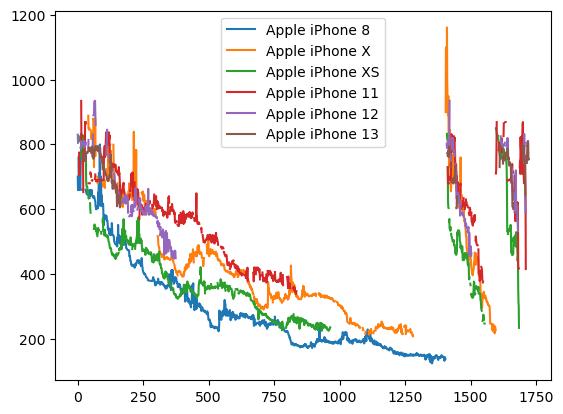

In [32]:
def get_data_from_keepa(product_list: list):

    dataset = pd.DataFrame()

    #apple
    col_name = 'NEW'

    #non-apple
    #col_name = 'USED'

    for product_code in product_list:
        products = api.query(product_code)
        product = products[0]
        name = products[0]['title'].split(',')[0]

        if product_code == product_list[0]:
            dataset = pd.DataFrame({'Date': product['data'][col_name+'_time'], name: product['data'][col_name]}, columns=['Date', name])
            dataset['Date'] = pd.to_datetime(dataset["Date"])
            dataset['Date'] = dataset['Date'].dt.date
            dataset = dataset.sort_values(by=['Date'])
            dataset = dataset.groupby('Date').mean().reset_index()
            today = dataset['Date'].iloc[-1]
            lastday = dataset['Date'].iloc[0]
            #print(today, lastday, lastday - today)
            dataset['Day'] =  abs((lastday - dataset['Date']).dt.days)# + (lastday - today).days
            dataset = dataset.drop(columns=['Date'])
        else:
            dataset_new = pd.DataFrame({'Date': product['data'][col_name+'_time'], name: product['data'][col_name]}, columns=['Date', name])
            dataset_new['Date'] = pd.to_datetime(dataset_new["Date"])
            dataset_new['Date'] = dataset_new['Date'].dt.date
            dataset_new = dataset_new.sort_values(by=['Date'])
            dataset_new = dataset_new.groupby('Date').mean().reset_index()
            today = dataset_new['Date'].iloc[-1]
            lastday = dataset_new['Date'].iloc[0]
            dataset_new['Day'] =  abs((lastday - dataset_new['Date']).dt.days)# + (lastday - today).days
            dataset_new = dataset_new.drop(columns=['Date'])

            dataset = pd.merge(dataset, dataset_new, how='outer', on=['Day'])
            #dataset = pd.merge(dataset, dataset_new, how='outer', on=['Date'])
    
    return dataset.drop_duplicates()

#iPhone
product_list = ['B0775MV9K2', 'B077578W38', 'B07SC58QBW', 'B07ZPKR714', 'B08PNCYYVZ', 'B09LNW3CY2']
#iPad Air
#product_list = ['B07GSL21XV', 'B07VMB5L3C', 'B08NPH29YG', 'B09V3HN1KC']
#Macbooks
#product_list = ['B078H42W49', 'B084Z6RK9C', 'B013HD3INW', 'B07BZF4MYM'] 
#Sony RX100
#product_list = ['B00889ST2G', 'B00DM8R866', 'B00K7O2DJU', 'B00ZDWGM34', 'B01MCRBY4X', 'B07DKG29RG', 'B07VPQV7BY']
#Samsung Fold


df = get_data_from_keepa(product_list)

df = df.drop(columns=['Day'])
df.plot()


#df


In [33]:
iPhone8 = pd.read_csv('Pairwise_iP8+X_Unnormalized.csv')
#iPhone8.columns = ['date', 'normalised_date', 'iPhone8', 'iPhoneX']
iPhone8 = iPhone8[['Day', 'iPhone 8']]
iPhone8.columns = ['date', 'actuals']
#iPhone8 = iPhone8.sort_values(by=["date"], ascending=True)
iPhone8 = iPhone8.reset_index(drop=True)
iPhone8.head(5)

,date,actuals
0,15/1/2018,699.99
1,29/1/2018,709.99
2,14/2/2018,659.98
3,28/2/2018,639.44
4,1/3/2018,659.00


In [34]:
import numpy as np

actual_vals = iPhone8.actuals.values
actual_log = np.log10(actual_vals)

In [35]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.tools as tls
from chart_studio import plotly

train, test = actual_vals[0:-70], actual_vals[-70:]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7)

In [36]:
#!pip install pyramid-arima
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(train_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic


/Users/ytsang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1721.301, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1847.815, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-1768.542, Time=0.02 sec


/Users/ytsang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-1876.560, Time=0.21 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-1851.226, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-1874.750, Time=0.31 sec


/Users/ytsang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(2,1,0)[7]             : AIC=-1874.462, Time=0.32 sec


/Users/ytsang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-1876.544, Time=0.34 sec


/Users/ytsang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-1872.734, Time=0.36 sec
 ARIMA(1,1,0)(2,1,0)[7] intercept   : AIC=-1874.806, Time=1.00 sec

Best model:  ARIMA(1,1,0)(2,1,0)[7]          
Total fit time: 5.738 seconds


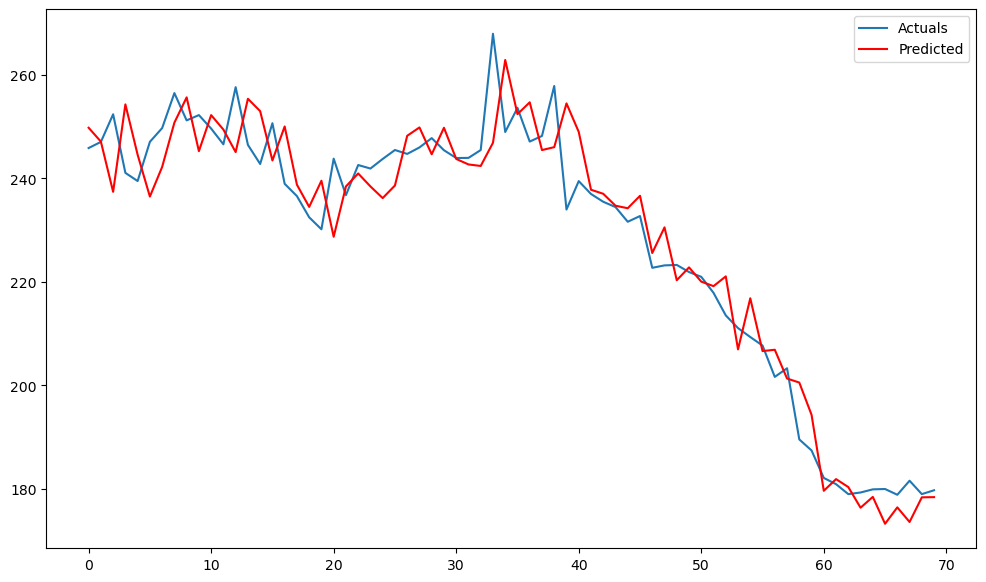

In [37]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
train, test = actual_vals[0:-70], actual_vals[-70:]
train_log, test_log = np.log10(train), np.log10(test)
# split data into train and test-sets
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [38]:
predicted_df=pd.DataFrame()
predicted_df['date']=iPhone8['date'][-70:]
predicted_df['actuals']=test
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,date,actuals,predicted
0,8/12/2019,245.880,249.799668
1,9/12/2019,247.058,247.125514
2,10/12/2019,252.400,237.415215
3,11/12/2019,241.080,254.315814
4,12/12/2019,239.500,244.578845


In [39]:
error = pd.DataFrame()
error['mse'] = (predicted_df['predicted']-predicted_df['actuals'])**2
print("MSE", error['mse'].sum())

MSE 3675.8319753587953
